In [1]:
"""Figure core creation: Fig3

Formatting of the figures may not be identical to the paper, but they contain the same data points.
"""

# pylint: disable=import-error, redefined-outer-name, use-dict-literal, too-many-lines, too-many-branches, consider-using-f-string, duplicate-code

'Figure core creation: Fig3\n\nFormatting of the figures may not be identical to the paper, but they contain the same data points.\n'

In [2]:
%load_ext autoreload
%autoreload 2

## Setup

In [3]:
from __future__ import annotations

from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import skops.io as skio
import upsetplot
from IPython.display import display

from epiclass.utils.notebooks.paper.paper_utilities import (
    ASSAY,
    ASSAY_ORDER,
    IHECColorMap,
    MetadataHandler,
    SplitResultsHandler,
)

In [4]:
CANCER = "harmonized_sample_cancer_high"
CORE_ASSAYS = ASSAY_ORDER[0:7]

### General paths setup

In [5]:
base_dir = Path.home() / "Projects/epiclass/output/paper"
paper_dir = base_dir
if not paper_dir.exists():
    raise FileNotFoundError(f"Directory {paper_dir} does not exist.")

base_data_dir = base_dir / "data"
base_fig_dir = base_dir / "figures"
tables_dir = base_dir / "tables"

base_metadata_dir = base_data_dir / "metadata"

In [6]:
IHECColorMap = IHECColorMap(base_fig_dir)
assay_colors = IHECColorMap.assay_color_map
cell_type_colors = IHECColorMap.cell_type_color_map
sex_colors = IHECColorMap.sex_color_map

In [7]:
split_results_handler = SplitResultsHandler()

metadata_handler = MetadataHandler(paper_dir)
metadata_v2 = metadata_handler.load_metadata("v2")
metadata_v2_df = metadata_handler.load_metadata_df("v2")

In [8]:
base_pred_dir = base_data_dir / "training_results" / "dfreeze_v2" / "predictions"
if not base_pred_dir.exists():
    raise FileNotFoundError(f"Directory {base_pred_dir} does not exist.")

## Context

### ChIP-Atlas

Predictions from following models and more:
| Metadata category|   Nb classes |     Experiment Key (comet.com)       | Training Files |
|------------------|--------------|--------------------------------------|----------|
| assay_epiclass   |     7      | 69488630801b4a05a53b5d9e572f0aaa       | 16788    |
| assay_epiclass   |     11      | 0f8e5eb996114868a17057bebe64f87c      | 20922    |
| harmonized_donor_sex | 3       | 4b908b83e0ec45c3ab991e65aa27af0c | 18299    |
| harmonized_donor_life_stage | 5    | 91214ed0b1664395b1826dc69a495ed4 | 15372    |
| harmonized_sample_cancer_high | 2    | 15da476b92f140eab818ece369248f4c | 20922    |
| harmonized_biomaterial_type | 4 | f42b6f4e147c4f1bbe378f3eed415099 | 20922 |


Classes:

- assay 7c: 6 h3k* histone marks + input
- assay 11c: assay7c + rna_seq + mrna_seq + wgbs_standard + wgbs_pbat
- harmonized_donor_sex: male, female, mixed
- harmonized_donor_life_stage: adult, child, newborn, fetal, embryonic
- harmonized_sample_cancer_high (modification of harmonized_sample_disease_high): cancer, non-cancer (healthy/None+disease)
- harmonized_biomaterial_type (biomat): cell line, primary cell, primary cell culture, primary tissue

Training metadata: Approximately `IHEC_sample_metadata_harmonization.v1.1.extended.csv`.
See `data/metadata/epiatlas/README.md` for metadata details, and `training_metadata_vs_official_v1.1.json` for exact difference of our training data and v1.1.

### recount3 predictions

Same classifiers as with ChIP-Atlas data

### ENCODE predictions

Same models as ChIP-Atlas predictions.
Additonally, the `harmonized_sample_ontology_intermediate` model was used on a subset of files with known EpiATLAS biospecimens.

| Metadata category|   Nb classes |     Experiment Key (comet.com)      | Training Files |
|-------------------------------------------|-------------|---------------------------------------|----------|
| harmonized_sample_ontology_intermediate   |     16      | bb66b72ae83645d587e50b34aebb39c3      | 16379    |

Metadata for ENCODE predictions created using:  
FILE + EXPERIMENT + BIOSAMPLE accessions, starting from filenames.  
See `src/python/epiclass/utils/notebooks/paper/encode_metadata_creation.ipynb`  
Final metadata file: `encode_full_metadata_2025-02_no_revoked.freeze1.csv(.xz)`  

## Fig 3

### Fig 3A - ENCODE dataset core/non-core predictions (5 tasks)

See `src/python/epiclass/utils/notebooks/paper/encode_pred_analysis.ipynb` at section `All 5 tasks metrics summary`  

Results were manually merged into Supplementary Table 9.

### Fig 3B - ChIP-Atlas assay (7classes) prediction

In [9]:
ca_preds_dir = tables_dir / "dfreeze_v2" / "predictions"
ca_preds_path = (
    ca_preds_dir / "ChIP-Atlas_predictions_20240606_merge_metadata_freeze1.csv.xz"
)
ca_preds_df = pd.read_csv(ca_preds_path, sep=",", low_memory=False, compression="xz")

print(f"ChIP-Atlas: {ca_preds_df.shape[0]} total files")

ChIP-Atlas: 48669 total files


Removing ChIP-Atlas experiment overlap with EpiATLAS

In [10]:
print(f"ChIP-Atlas: Initial {ca_preds_df.shape[0]} files")
no_epiatlas_df = ca_preds_df[ca_preds_df["is_EpiAtlas_EpiRR"] == "0"]

diff = ca_preds_df.shape[0] - no_epiatlas_df.shape[0]
print(f"ChIP-Atlas: {diff} files with EpiAtlas EpiRR removed")
print(f"ChIP-Atlas: {no_epiatlas_df.shape[0]} files without EpiAtlas EpiRR")

ChIP-Atlas: Initial 48669 files
ChIP-Atlas: 1047 files with EpiAtlas EpiRR removed
ChIP-Atlas: 47622 files without EpiAtlas EpiRR


Ignoring non-core consensus files.

In [11]:
non_core_labels = ["non-core", "CTCF"]
ca_core7_df = no_epiatlas_df[
    ~no_epiatlas_df["target_majority_consensus"].isin((non_core_labels))
]

diff = no_epiatlas_df.shape[0] - ca_core7_df.shape[0]
print(f"ChIP-Atlas: {diff} files with non-core consensus removed")
print(f"ChIP-Atlas: {ca_core7_df.shape[0]} files with core consensus")

display(ca_core7_df["target_majority_consensus"].value_counts(dropna=False))

ChIP-Atlas: 918 files with non-core consensus removed
ChIP-Atlas: 46704 files with core consensus


input           17930
h3k27ac         11169
h3k4me3          6328
h3k27me3         4195
h3k4me1          3034
h3k9me3          2102
h3k36me3         1421
no_consensus      525
Name: target_majority_consensus, dtype: int64

#### High-confidence predictions

In [12]:
total_N = ca_core7_df.shape[0]
high_confidence_pred_df = ca_core7_df[ca_core7_df["Max_pred_assay7"] >= 0.6]

high_confidence_N = high_confidence_pred_df.shape[0]
N_percent = high_confidence_N / total_N
display(
    f"ChIP-Atlas: {high_confidence_N}/{total_N} files ({high_confidence_N/total_N:.2%}) with high confidence assay prediction"
)

'ChIP-Atlas: 41796/46704 files (89.49%) with high confidence assay prediction'

#### Match between manual target consensus and MLP prediction

In [13]:
total_N = high_confidence_pred_df.shape[0]

match_rule = (
    high_confidence_pred_df["target_majority_consensus"]
    == high_confidence_pred_df["Predicted_class_assay7"]
)
match_df = high_confidence_pred_df[match_rule]
mismatch_df = high_confidence_pred_df[~match_rule]

agreement_N = match_df.shape[0]

print(
    f"ChIP-Atlas: {agreement_N}/{total_N} files ({agreement_N / total_N:.2%}) with agreement between consensus and predicted assay"
)

ChIP-Atlas: 39532/41796 files (94.58%) with agreement between consensus and predicted assay


#### Mismatch breakdown

In [14]:
total_mismatch = mismatch_df.shape[0]
input_rule = mismatch_df["Predicted_class_assay7"] == "input"
input_pred_N = input_rule.sum()

print(
    f"ChIP-Atlas: {input_pred_N}/{total_mismatch} files ({input_pred_N / total_mismatch:.2%}) with mismatch predicted as input"
)
print(
    f"ChIP-Atlas: {total_mismatch-input_pred_N}/{total_mismatch} files ({(total_mismatch-input_pred_N) / total_mismatch:.2%}) potential mislabels"
)
display(mismatch_df[~input_rule]["core7_DBs_consensus"].value_counts(dropna=False))

ChIP-Atlas: 1525/2264 files (67.36%) with mismatch predicted as input
ChIP-Atlas: 739/2264 files (32.64%) potential mislabels


Identical                       468
Different                       158
Ignored - Potential non-core     64
1 source                         49
Name: core7_DBs_consensus, dtype: int64

### Fig 3C-J

See Supp Fig 8.

## Supp Fig 6

See src/python/epiclass/utils/notebooks/paper/confidence_threshold.ipynb

## Supp Fig 8

### Fig 3C-J + Supp Fig 8A,D - Public databases: Metrics for know labels

ChIP-Atlas, ENCODE and recount3 metrics are generated in their respective file, using `MetricsPerAssay` class (from `src/python/epiclass/utils/notebooks/paper/metrics_per_assay.py`).

- ChIP-Atlas: `src/python/epiclass/utils/notebooks/paper/c-a_pred_analysis.ipynb` (section `Summary metrics by assay`)
- ENCODE: `src/python/epiclass/utils/notebooks/paper/encode_pred_analysis.ipynb` (section `All 5 tasks metrics summary`, run `Setup` section beforehand)
- recount3: `src/python/epiclass/utils/notebooks/paper/recount3_pred_analysis.ipynb`

Results were manually merged into Supplementary Table 10.

### Supp Fig 8B - ENCODE non-core predictions with assay category mapping

In [15]:
encode_meta_dir = base_data_dir / "metadata" / "encode"

In [16]:
encode_preds_dir = base_pred_dir / "encode"
encode_preds_path = (
    encode_preds_dir / "complete_encode_predictions_augmented_2025-02_metadata.csv.gz"
)
encode_preds_df = pd.read_csv(
    encode_preds_path, sep=",", low_memory=False, compression="gzip"
)
print(f"ENCODE: {encode_preds_df.shape[0]} total files")

ENCODE: 11643 total files


In [17]:
encode_preds_df = encode_preds_df[encode_preds_df["in_epiatlas"].astype(str) == "False"]
print(f"ENCODE: {encode_preds_df.shape[0]} total files with no EpiAtlas overlap")

ENCODE: 8777 total files with no EpiAtlas overlap


In [18]:
non_core_categories_path = (
    encode_meta_dir / "non-core_encode_assay_category_2024-08-29.csv"
)

non_core_categories_df = pd.read_csv(non_core_categories_path, sep=",", low_memory=False)
print(f"ENCODE: {non_core_categories_df.shape[0]} non-core categories")

non_core_map = non_core_categories_df.set_index("target").to_dict()["Assay category"]

ENCODE: 1170 non-core categories


In [19]:
N_mapped = len([val for val in non_core_map.values() if val != "not_looked"])
print(f"ENCODE: {N_mapped} non-core categories mapped to functional categories.")

ENCODE: 238 non-core categories mapped to functional categories.


In [20]:
encode_non_core_df = encode_preds_df[
    encode_preds_df[ASSAY].isin(["non-core", "ctcf"])
].copy()

# Map assays to categories
encode_non_core_df["assay_category"] = (
    encode_non_core_df["assay"].str.lower().replace(non_core_map)
)

In [21]:
assay_categories_order = [
    "trx_reg",
    "heterochrom",
    "polycomb",
    "splicing",
    "insulator",
    "other/mixed",
    "not_looked",
]

assay_epiclass_order = [
    "h3k27ac",
    "h3k4me3",
    "h3k4me1",
    "h3k9me3",
    "h3k27me3",
    "h3k36me3",
    "input",
]
assay_epiclass_order = {assay: i for i, assay in enumerate(assay_epiclass_order)}
pred_col = f"Predicted class ({ASSAY}_7c)"
max_pred_col = f"Max pred ({ASSAY}_7c)"

for min_pred in [0, 0.6]:
    sub_df = encode_non_core_df[encode_non_core_df[max_pred_col] >= min_pred]
    groupby = (
        sub_df.groupby(["assay_category", pred_col])
        .size()
        .reset_index(name="Count")
        .sort_values(["assay_category", "Count"], ascending=[True, False])
    )
    groupby["Percentage"] = groupby.groupby("assay_category")["Count"].transform(
        lambda x: (x / x.sum()) * 100
    )

    # Add order for plotting
    groupby["assay_order"] = groupby[pred_col].map(assay_epiclass_order)
    groupby = groupby.sort_values(
        ["assay_category", "assay_order"], ascending=[False, True]
    )

    # Main plot
    fig = px.bar(
        groupby,
        x="assay_category",
        y="Percentage",
        color=pred_col,
        barmode="stack",
        category_orders={"assay_category": assay_categories_order},
        color_discrete_map=assay_colors,
        title=f"core7 predictions for non-core assays, predScore >= {min_pred:.2f}",
        labels={"Percentage": "Percentage (%)", "assay_category": "Assay Category"},
    )

    # Modify x-axis labels
    total_counts = groupby.groupby("assay_category")["Count"].sum()
    ticktext = [
        f"{assay_category} (N={total_counts[assay_category]})"
        for assay_category in assay_categories_order
    ]
    fig.update_xaxes(tickvals=assay_categories_order, ticktext=ticktext)
    fig.show()

### Supp Fig 8C,F,I - PCAs

PCAs were computed via `src/python/epiclass/utils/compute_pca.py`, using `IncrementalPCA` from `scikit-learn`.  
Graphing was done using code similar to `src/python/epiclass/utils/notebooks/paper/pca_plot.ipynb`, which uses the output of `compute_pca.py`.  

In [22]:
# Create PCA tables, which include filenames

pca_dir = base_data_dir / "pca"
chip_dir = pca_dir / "chip_3projects"
rna_dir = pca_dir / "rna_enc_epi_recount3"
encode_dir = pca_dir / "epiatlas_encode"

for folder in [chip_dir, rna_dir, encode_dir]:
    if not folder.exists():
        raise FileNotFoundError(f"Folder {folder} does not exist.")

    results_path = list(folder.glob("X_IPCA_*.skops"))
    if len(results_path) != 1:
        raise ValueError(
            f"Expected 1 results file in {folder}, found {len(results_path)}"
        )
    results_path = results_path[0]

    data = skio.load(results_path)
    print(folder.name, data["X_ipca"].shape)

    filenames = pd.DataFrame(data["file_names"], columns=["filename"])
    filenames.to_csv(
        folder / results_path.name.replace(".skops", "_filenames.list"),
        index=False,
        header=False,
    )

    results = data["X_ipca"]

    results_df = pd.DataFrame(
        results, columns=[f"PC{i+1}" for i in range(results.shape[1])]
    )
    results_df = pd.concat([filenames, results_df], axis=1)

    new_name = results_path.name.replace(".skops", ".csv.xz")
    new_name = new_name.replace("X_IPCA", f"{folder.name}_X_IPCA")

    results_df.to_csv(
        folder / new_name,
        index=True,
        header=True,
        compression="xz",
    )

chip_3projects (65960, 3)
rna_enc_epi_recount3 (54531, 3)
epiatlas_encode (29699, 3)


### Supp Fig 5E - UpsetPlot of assay labels provided in 4 DBs

In [23]:
for col in ca_core7_df.columns:
    if "consensus" in col:
        print(col)

core7_DBs_consensus
target_majority_consensus


In [24]:
consensus_col = "core7_DBs_consensus"

In [25]:
def create_4DB_consensus_description(
    ca_core_df: pd.DataFrame, db_cols: List[str]
) -> pd.Series:
    """Create a description of the 4DB assay consensus labels.

    Treat "Unclassified" from Chip-Atlas as absent samples for the target consensus evaluation.

    The consensus description is based on the following rules:
    - "Identical" if all labels are the same
    - "Different" if at least one label is different
    - "1 source" if only one DB has a label
    - "Ignored - Potential non-core" if any label is not in the core assays

    Args:
        ca_core_df: ChIP-Atlas core7 DataFrame

    Returns:
        Series with the target consensus description
    """
    id_db_target = []
    tmp_df = ca_core_df.loc[:, db_cols].copy()
    tmp_df["C-A"].replace("unclassified", "----", inplace=True)

    for labels in tmp_df.values:
        missing_N = sum(label == "----" for label in labels)
        db_labels = set(labels)

        try:
            db_labels.remove("----")
        except KeyError:
            pass
        if any(label not in CORE_ASSAYS + ["ctrl"] for label in db_labels):
            id_db_target.append("Ignored - Potential non-core")
        elif missing_N == 3:
            id_db_target.append("1 source")
        elif len(db_labels) == 1:
            id_db_target.append("Identical")
        else:
            id_db_target.append("Different")

    return pd.Series(id_db_target, index=ca_core_df.index)

In [26]:
def make_db_upsetplot(
    df: pd.DataFrame, consensus_col: str, db_cols: List[str], title: str
) -> upsetplot.UpSet:
    """Make an upsetplot of the sample presence in the different databases."""
    df = df.copy()

    # Create a new DataFrame with boolean columns for each database
    upset_df = pd.DataFrame()
    for col in db_cols:
        upset_df[col] = df[col] != "----"
    upset_df[consensus_col] = df[consensus_col]

    # Set the index for the UpSet plot
    upset_df = upset_df.set_index(db_cols)

    # Create the UpSet plot
    upset = upsetplot.UpSet(
        upset_df,
        intersection_plot_elements=0,  # disable the default bar chart
        sort_by="cardinality",
        show_counts=True,  # type: ignore
        orientation="horizontal",
    )

    # Add stacked bars
    upset.add_stacked_bars(by=consensus_col, elements=15)

    # Plot and set title
    axes = upset.plot()
    plt.suptitle(title)
    axes["totals"].set_title("Total")
    plt.legend(loc="center left")
    plt.show()
    return upset

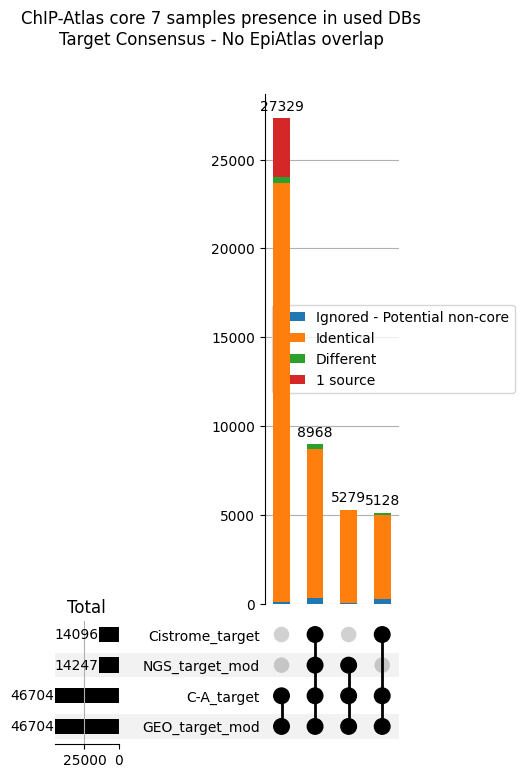

In [27]:
DB_COLS = ["GEO_target_mod", "C-A_target", "Cistrome_target", "NGS_target_mod"]
title = "ChIP-Atlas core 7 samples presence in used DBs\nTarget Consensus - No EpiAtlas overlap"
upset = make_db_upsetplot(
    df=ca_core7_df, consensus_col=consensus_col, db_cols=DB_COLS, title=title
)

### Supp Fig 8G - ChIP-Atlas mislabeled datasets

Genome browser screenshots, using coordinates and samples specified in the image.

### Supp Fig 8H - Effect of EpiATLAS imputation on assay (7 classes) training and inference

In [28]:
imputed_metadata_path = (
    base_metadata_dir
    / "epiatlas"
    / "imputed"
    / "hg38_epiatlas_imputed_pval_chip_2024-02.json"
)
metadata_imputed: pd.DataFrame = metadata_handler.load_any_metadata(imputed_metadata_path, as_dataframe=True)  # type: ignore

In [29]:
ca_metadata_path = base_metadata_dir / "chip_atlas" / "CA.full_info_metadata.freeze1.tsv"
metadata_ca = pd.read_csv(ca_metadata_path, sep="\t", low_memory=False)

In [30]:
data_dir = base_data_dir / "training_results" / "dfreeze_v2"
pred_dfs = {}  # Gather all 4 cases

Gather predictions from classifier training on observed core6 data (all pval, no input)

In [31]:
observed_dir = (
    data_dir
    / "hg38_100kb_all_none"
    / "assay_epiclass_1l_3000n"
    / "chip-seq-only"
    / "complete_no_valid_oversample"
)
observed_inf_imputed_path = next((observed_dir / "predict_imputed").glob("*.csv"))
observed_inf_CA_path = next((observed_dir / "predict_C-A").glob("*.csv"))

basename = "observed_core6_pval_inf"

In [32]:
df = pd.read_csv(observed_inf_imputed_path, header=0, index_col=0, low_memory=False)
df = pd.merge(df, metadata_imputed, left_index=True, right_on="md5sum")
df["True class"] = df[ASSAY]

print(f"Imputed: {df.shape[0]} total files")
pred_dfs[f"{basename}_imputed"] = df

Imputed: 9570 total files


In [33]:
df = pd.read_csv(observed_inf_CA_path, header=0, index_col=0, low_memory=False)
df = pd.merge(df, metadata_ca, left_index=True, right_on="ID")
df["True class"] = df["expected_assay"]
print(f"CA: {df.shape[0]} total files")

display(df["expected_assay"].value_counts(dropna=False))
pred_dfs[f"{basename}_C-A"] = df

CA: 29105 total files


h3k27ac     11316
h3k4me3      6501
h3k27me3     4319
h3k4me1      3177
h3k9me3      2228
h3k36me3     1564
Name: expected_assay, dtype: int64

Gather predictions from classifier training on imputed data (all pval, no input)

In [34]:
imputed_dir = (
    data_dir
    / "hg38_100kb_all_none_imputed"
    / "assay_epiclass_1l_3000n"
    / "chip-seq-only"
    / "complete_no_valid_oversample"
)
imputed_inf_observed_path = next(
    (imputed_dir / "predict_epiatlas_pval_chip-seq").glob("*.csv")
)
imputed_inf_CA_path = next((imputed_dir / "predict_C-A").glob("*.csv"))

basename = "imputed_core6_pval_inf"

In [35]:
df = pd.read_csv(imputed_inf_observed_path, header=0, index_col=0, low_memory=False)
df = pd.merge(df, metadata_v2_df, left_index=True, right_on="md5sum")
df["True class"] = df[ASSAY]

print(f"EpiATLAS pval ChIP: {df.shape[0]} total files")
pred_dfs[f"{basename}_obs_core6_pval"] = df

EpiATLAS pval ChIP: 5337 total files


In [36]:
df = pd.read_csv(imputed_inf_CA_path, header=0, index_col=0, low_memory=False)
df = pd.merge(df, metadata_ca, left_index=True, right_on="ID")
df["True class"] = df["expected_assay"]

print(f"CA: {df.shape[0]} total files")
pred_dfs[f"{basename}_C-A"] = df

CA: 29105 total files


Compute accuracy per assay

In [37]:
this_fig_dir = base_fig_dir / "fig3" / "imputation_effect"

In [38]:
core6_assays = ASSAY_ORDER[0:6]

In [39]:
rows = []

for name, df in pred_dfs.items():
    if "Max pred" not in df.columns:
        df["Max pred"] = df[core6_assays].max(axis=1)

    task_name = f"train_{name}"

    for label in core6_assays:
        assay_df = df[df["True class"] == label]

        for min_pred in ["0.0", "0.6", "0.9"]:
            sub_df = assay_df[assay_df["Max pred"] > float(min_pred)]
            acc = (sub_df["True class"] == sub_df["Predicted class"]).mean()
            rows.append([task_name, label, min_pred, acc, len(sub_df)])

df_acc_per_assay = pd.DataFrame(
    rows, columns=["task_name", "assay", "min_predScore", "acc", "nb_samples"]
)

df_acc_per_assay.to_csv(
    this_fig_dir / "imputation_impact_acc_per_assay.tsv", sep="\t", index=False
)

Graphing results

In [40]:
save_fig = False

In [41]:
min_predScore_color_map = {"0.0": "blue", "0.6": "orange", "0.9": "red"}

df_acc_per_assay["scatter_name"] = (
    df_acc_per_assay["task_name"]
    .replace("train_", "", regex=True)
    .replace("imputed", "imp", regex=True)
    .replace("observed", "obs", regex=True)
)
df_acc_per_assay["inf_target"] = df_acc_per_assay["scatter_name"].str.split("_").str[-1]

df_acc_per_assay = df_acc_per_assay.sort_values(
    ["assay", "min_predScore", "scatter_name"]
)

In [42]:
graph_type = "all"
# graph_type = "no_C-A"
# graph_type = "only_C-A"
# graph_type = "only_C-A+core7"

if graph_type == "all":
    minY = 0.7
    maxY = 1.005
elif graph_type == "no_C-A":
    minY = 0.97
    maxY = 1.001
elif graph_type == "only_C-A":
    minY = 0.7
    maxY = 1.005
else:
    raise ValueError(f"Unknown graph_type: {graph_type}")

graph_df = df_acc_per_assay.copy()
graph_df = graph_df.sort_values(["inf_target", "scatter_name"])
if graph_type == "no_C-A":
    graph_df = graph_df[graph_df["inf_target"] != "C-A"]
elif "only_C-A" in graph_type:
    graph_df = graph_df[graph_df["inf_target"] == "C-A"]

if graph_type != "only_C-A+core7":
    graph_df = graph_df[~graph_df["scatter_name"].str.contains("core7")]


# Prepare boxplot data
tick_group = [
    "obs_core6_pval_inf_imp",
    "imp_core6_pval_inf_obs_core6_pval",
    "obs_core6_pval_inf_C-A",
    "imp_core6_pval_inf_C-A",
]
scatter_name_to_position = {name: i for i, name in enumerate(tick_group)}

min_pred_values = ["0.0", "0.6", "0.9"]
offset = [-0.25, 0, 0.25]  # Offset for each min_pred within a tick group

# Define jitter magnitude (like 0.05 for left/right spacing)
jitter = 0.05
jitter_offsets = [-jitter, 0, jitter]

fig = go.Figure()
for name in tick_group:
    group = graph_df[graph_df["scatter_name"] == name]

    for i, min_pred in enumerate(min_pred_values):
        df_subset = group[group["min_predScore"] == min_pred]

        x_position = scatter_name_to_position[name] + offset[i]
        x_positions = [x_position] * len(df_subset)
        y_values = df_subset["acc"]
        hover_texts = [
            f"{row['assay']}<br>Samples: {row['nb_samples']}"
            for _, row in df_subset.iterrows()
        ]
        colors = [assay_colors[assay] for assay in df_subset["assay"]]

        # Add box plot without points
        fig.add_trace(
            go.Box(
                x=x_positions,
                y=y_values,
                name=f"{name} - Min Pred Score: {min_pred}",
                line=dict(
                    color=min_predScore_color_map[min_pred],
                ),
                boxpoints="all",
                marker=dict(
                    opacity=0, size=1e-5
                ),  # hide points, so whiskers don't go to min/max
                boxmean=True,
                showlegend=False,
                hoverinfo="none",
            )
        )
        # Add scatter plot for individual points
        x_jittered = [
            x + jitter_offsets[i % len(jitter_offsets)] for i, x in enumerate(x_positions)
        ]

        # sort x/y together
        x_jittered, y_values, hover_texts = zip(
            *sorted(zip(x_jittered, y_values, hover_texts))
        )
        fig.add_trace(
            go.Scatter(
                x=x_jittered,
                y=y_values,
                mode="markers",
                marker=dict(color=colors, size=8, line=dict(color="Black", width=1)),
                name=f"{name} - Min Pred Score: {min_pred}",
                showlegend=False,
                text=hover_texts,
                hoverinfo="text+y",
            )
        )

# Update x-axis tick labels
ticktext = []
for tick in tick_group:
    train, inf = tick.split("_inf_")
    ticktext.append(f"<b>{train}</b> \u2192 <b>{inf}</b>")

fig.update_xaxes(tickmode="array", ticktext=ticktext, tickvals=list(range(len(ticktext))))

# Update layout
fig.update_layout(
    title="Accuracy per Task (6 core assays)",
    xaxis_title="Task (training data \u2192 inference data)",
    yaxis_title="Accuracy",
    showlegend=True,
    height=600,
    width=1000,
    yaxis=dict(tickformat=".2%", range=[minY, maxY]),
)

# Add a legend for minPred colors
for val, color in min_predScore_color_map.items():
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode="markers",
            marker=dict(size=10, color=color, symbol="square"),
            name=f"Min Pred Score: {val}",
            showlegend=True,
        )
    )

# Add a legend for assay colors
for assay in sorted(core6_assays):
    color = assay_colors[assay]
    fig.add_trace(
        go.Scatter(
            x=[None],
            y=[None],
            mode="markers",
            marker=dict(size=10, color=color),
            name=assay,
            legendgroup="assays",
            showlegend=True,
        )
    )

# Add legend for obs and imp
fig.add_annotation(
    x=1.2,
    y=0.2,
    yref="paper",
    xref="paper",
    text="obs = observed<br>imp = imputed",
    showarrow=False,
    font=dict(size=14),
)

if save_fig:
    name = "imputation_impact_acc_per_assay"
    fig.write_image(this_fig_dir / f"{name}.png")
    fig.write_image(this_fig_dir / f"{name}.svg")
    fig.write_html(this_fig_dir / f"{name}.html")

fig.show()